### Content Analysis Political -Racism
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("political/Topics_FB_Political_Posts_per_partyracism.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(1670, 35)

In [5]:

posts.shape

(1670, 35)

In [6]:
posts['URL']

0       https://www.facebook.com/latinosvstrump/posts/...
1       https://www.facebook.com/latinosvstrump/posts/...
2       https://www.facebook.com/latinosvstrump/posts/...
3       https://www.facebook.com/LatinosforJoe/posts/5...
4       https://www.facebook.com/latinosvstrump/posts/...
                              ...                        
1665    https://www.facebook.com/groups/16256741844186...
1666    https://www.facebook.com/groups/16256741844186...
1667    https://www.facebook.com/groups/16256741844186...
1668    https://www.facebook.com/groups/16256741844186...
1669    https://www.facebook.com/groups/16256741844186...
Name: URL, Length: 1670, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [7]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [8]:
posts.columns

Index(['Unnamed: 0', 'Group Name', 'User Name', 'Facebook Id',
       'Likes at Posting', 'Created', 'Type', 'Likes', 'Comments', 'Shares',
       'Love', 'Wow', 'Haha', 'Sad', 'Angry', 'Care', 'Video Share Status',
       'Post Views', 'Total Views', 'Total Views For All Crossposts',
       'Video Length', 'URL', 'Message', 'Link', 'Final Link', 'Image Text',
       'Link Text', 'Description', 'Sponsor Id', 'Sponsor Name',
       'Total Interactions', 'Overperforming Score', 'MessageDescr',
       'MessageOnly', 'party'],
      dtype='object')

In [9]:
posts["Created"].head(5)

0    2020-10-31 10:03:17 EDT
1    2020-09-22 16:01:07 EDT
2    2020-08-27 19:29:55 EDT
3    2020-09-10 17:29:19 EDT
4    2020-10-14 19:13:44 EDT
Name: Created, dtype: object

In [10]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-10-31 10:03:17-04:00
1      2020-09-22 16:01:07-04:00
2      2020-08-27 19:29:55-04:00
3      2020-09-10 17:29:19-04:00
4      2020-10-14 19:13:44-04:00
                  ...           
1665   2020-08-29 23:37:22-04:00
1666   2020-08-29 20:15:43-04:00
1667   2020-08-27 02:18:47-04:00
1668   2020-08-21 15:53:10-04:00
1669   2020-08-20 12:46:58-04:00
Name: converted_date, Length: 1670, dtype: datetime64[ns, tzlocal()]

In [11]:
posts['converted_date']=posts['converted_date'].dt.date

In [12]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,21
1,2020-08-19,15
2,2020-08-20,12
3,2020-08-21,17
4,2020-08-22,16
5,2020-08-23,8
6,2020-08-24,17
7,2020-08-25,40
8,2020-08-26,23
9,2020-08-27,39


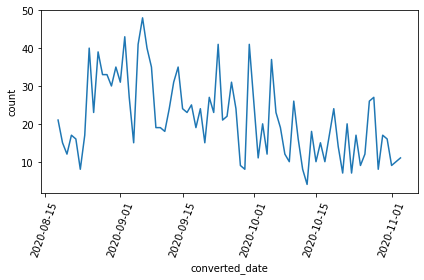

In [13]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [14]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,Group Name,User Name,Facebook Id,Likes at Posting,Created,Type,Likes,Comments,Shares,...,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,party,converted_date
2,117,Latinos Contra Trump,latinosvstrump,1161597243956409,229773.0,2020-08-27 19:29:55 EDT,Link,44,280,19,...,Gracias Querido Presidente Trump: Este es el T...,El concepto de Trump de hacer a “América Grand...,NaN,NaN,473,1.53,Este va directo para el que todavía tenga duda...,Este va directo para el que todavía tenga duda...,Democrat,2020-08-27


In [15]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [16]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [17]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

## 3. Which groups are publishing the majority of the content

In [18]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Latinos For Trump -California Group,299
DONALD TRUMP PARA HISPANOS,170
Latinos For Trump.,149
CARA - Cuban American Republican Alliance,113
Mexicans for Donald Trump,106
Republican National Hispanic Assembly - Official Group,58
Latinos Against Donald Trump,53
African Americans & Latinos for Biden & Harris,47
Kentucky republican latinos,44


## Tokenize words and Clean-up text

In [19]:
content = posts.copy()
content.drop_duplicates(subset= ['MessageDescr'], inplace=True)
content['MessageDescr']

0       Racismo, enfoque divisivo e indecencia siguen ...
1       De aprobarse, los supremacistas podrían lanzar...
2       Este va directo para el que todavía tenga duda...
3       Doral, home of Venezuelans in Florida, went cr...
4       A eso es lo que realmente quieren llegar: a vo...
5       Nominada de Trump al Supremo Bajo Fuego por De...
6       Fíjate bien. No es por siglos de EXPLOTACIÓN y...
7       El Maestro de la Distracción intenta otra de l...
8       Our right to vote has been oppressed since it ...
9       NO. No existe la "libertad de expresión" cuand...
10      This is the kind of leader we need: someone wh...
11      In North Carolina making the case to the Afric...
12      This is just amazing. https://www.nbcnews.com/...
13      yes BREAKING: Portland's Mayor just SLAMMED Tr...
14      North Carolina is almost as bad as Texas in in...
15       Join us on Monday, October 12th to celebrate ...
16      He won't be absolved; he was a part of it all....
17      Answer

In [20]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(1369,)

In [21]:
# Convert to list
data = content.cleanMessage.tolist()

In [22]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [23]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['racismo', 'enfoque', 'divisivo', 'indecencia', 'siguen', 'siendo', 'las', 'cartas', 'de', 'triunfo', 'del', 'gran', 'donald', 'desde', 'difamar', 'los', 'medicos', 'que', 'salvan', 'vidas', 'hasta', 'el', 'nombre', 'de', 'la', 'futura', 'vicepresidente', 'harris', 'la', 'ultima', 'parada', 'de', 'la', 'campana', 'de', 'trump', 'fue', 'una', 'completa', 'desgracia', 'trump', 'se', 'burla', 'alegremente', 'del', 'nombre', 'de', 'kamala', 'en', 'un', 'discurso', 'racista', 'exacerba', 'los', 'animos', 'de', 'sus', 'fans'], ['de', 'aprobarse', 'los', 'supremacistas', 'podrian', 'lanzarte', 'su', 'carro', 'encima', 'alegar', 'que', 'lo', 'hicieron', 'por', 'seguridad', 'el', 'compinche', 'floridano', 'de', 'trump', 'lanza', 'un', 'ataque', 'aterrador', 'contra', 'la', 'primera', 'enmienda', 'gobernador', 'rep', 'propone', 'ley', 'que', 'criminaliza', 'las', 'protestas', 'de', 'blm', 'legaliza', 'lanzar', 'el', 'carro', 'los', 'manifestantes']]


#### Creating Bigram and Trigram Models

In [24]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['racismo', 'enfoque', 'divisivo', 'indecencia', 'siguen', 'siendo', 'las', 'cartas', 'de', 'triunfo', 'del', 'gran', 'donald', 'desde', 'difamar', 'los', 'medicos', 'que', 'salvan', 'vidas', 'hasta', 'el', 'nombre', 'de', 'la', 'futura', 'vicepresidente', 'harris', 'la', 'ultima', 'parada', 'de', 'la', 'campana', 'de', 'trump', 'fue', 'una', 'completa', 'desgracia', 'trump', 'se', 'burla', 'alegremente', 'del', 'nombre', 'de', 'kamala', 'en', 'un', 'discurso', 'racista', 'exacerba', 'los', 'animos', 'de', 'sus', 'fans']


## Remove Stopwords, Make Bigrams and Lemmatize

In [25]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python3 -m spacy download en
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [28]:
data_lemmatized[0]

['racismo',
 'enfocar',
 'divisivo',
 'indecencia',
 'seguir',
 'carta',
 'triunfar',
 'gran',
 'difamar',
 'medicos',
 'vida',
 'nombrar',
 'futuro',
 'vicepresidente',
 'harris',
 'ultimar',
 'parar',
 'campana',
 'trump',
 'completo',
 'desgraciar',
 'trump',
 'burlar',
 'alegremente',
 'nombrar',
 'discursar',
 'racista',
 'exacerbar',
 'animos',
 'fan']

In [29]:
print(data_words_nostops[1:2])

[['aprobarse', 'supremacistas', 'podrian', 'lanzarte', 'carro', 'encima', 'alegar', 'hicieron', 'seguridad', 'compinche', 'floridano', 'trump', 'lanza', 'ataque', 'aterrador', 'primera', 'enmienda', 'gobernador', 'rep', 'propone', 'ley', 'criminaliza', 'protestas', 'blm', 'legaliza', 'lanzar', 'carro', 'manifestantes']]


## Bag of Words

In [30]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [31]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [32]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [33]:
final_dict.most_common(1000)

[('donald / trump', 814),
 ('america', 215),
 ('president / presidente', 142),
 ('democrats', 95),
 ('hacer', 87),
 ('racismo', 80),
 ('votar', 80),
 ('ano', 77),
 ('country', 76),
 ('donar', 69),
 ('racial', 68),
 ('medio', 65),
 ('really', 64),
 ('decir', 60),
 ('personar', 55),
 ('also', 52),
 ('race', 51),
 ('partir', 49),
 ('ver', 48),
 ('querer', 48),
 ('democratas', 48),
 ('post', 48),
 ('debatir', 46),
 ('acusar', 46),
 ('political', 45),
 ('solo', 45),
 ('negro', 44),
 ('sexual', 44),
 ('usar', 43),
 ('grupo', 42),
 ('comunista', 42),
 ('federal', 41),
 ('unir', 41),
 ('gente', 40),
 ('ir', 39),
 ('liberal', 39),
 ('socialista', 39),
 ('izquierdo', 38),
 ('justice', 37),
 ('hoy', 37),
 ('ser', 37),
 ('control', 37),
 ('luchar', 37),
 ('tambien', 37),
 ('color', 36),
 ('mundo', 36),
 ('radical', 35),
 ('dar', 35),
 ('real', 34),
 ('virus', 34),
 ('nuevo', 33),
 ('mayor', 33),
 ('photos', 33),
 ('vida', 32),
 ('ley', 32),
 ('libertar', 32),
 ('crear', 32),
 ('pasar', 32),
 ('mar

In [34]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [35]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [36]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [37]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
trump,2.361780
america,3.288092
votar,4.003058
democrats,4.063683
country,4.079431
racismo,4.079431
presidente,4.233582
medio,4.252274
hacer,4.310543
post,4.330746


In [38]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
nombrar,0.347982
alegremente,0.203715
divisivo,0.203715
indecencia,0.203715
animos,0.203715
fan,0.203715
triunfar,0.203715
exacerbar,0.203715
difamar,0.203715
desgraciar,0.203715


In [40]:
pd.set_option('display.max_colwidth',None)
#word = df.index[8]
word = r"\b(evento)\b"
content["lowercase"] = content['MessageOnly'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')

word_messages

/home/claudia/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


unique_messages  \
0  datos importantes para conocer mas sobre lo que ha hecho el presidente trump: el presidente trump construyó la mejor economía del mundo y lo volverá a hacer bajo el presidente trump, volveremos a nuestra prosperidad. esta noche el presidente trump llevará a cabo un evento destacando el gran regreso estadounidense en mosinee, wisconsin. en agosto: se agregaron 1.4 millones de empleos de nuevo a la economía y la tasa de desempleo disminuyó. la tasa de desempleo de las mujeres disminuyó por 2%. la tasa de desempleo para la comunidad afroamericana cayó un 1.6%. la tasa de desempleo de los hispanos estadounidenses cayó un 2.4%. la tasa de desempleo asiática-estadounidense cayó un 1.3%. en los últimos 4 meses, se agregaron más de 10 millones de empleos a la economía, lo cual es casi la mitad de los empleos perdidos durante la pandemia mundial. los esfuerzos del presidente trump para proteger a los trabajadores y a empresas estadounidenses durante la pandemia del coronavirus claramente han funcionado. operación “warp speed” nos ha acercado a lograr una vacuna que nos ayudará a reabrir la economía en su totalidad. seguimos en camino para tener una vacuna segura antes del fin de año. la administración trump emitió un plan nacional detallado de distribución de vacunas. el objetivo es permitir que las personas más vulnerables y de mayor riesgo se vacunen en el primer grupo. joe biden y kamala harris están usando una retórica peligrosa sobre la vacuna contra el coronavirus. joe biden sería la peor persona para poner a cargo de la economía. biden y los demócratas inmediatamente causarían el colapso de la economía. como vicepresidente, presidió la peor recuperación desde la gran depresión. el plan económico de joe biden incluye un aumento masivo de impuestos de $4 trillones para los estadounidenses trabajadores. el 82% de las familias verían un aumento en sus impuestos bajo el plan fiscal de biden. biden votó a favor del acuerdo comercial tlcan que eliminó a 850,000 empleos estadounidenses. biden ha prometido que "lo primero" que haría sería derogar la ley de empleos y recortes de impuestos. joe biden cerraría a la economía de nuevo. el nuevo acuerdo ecológico eliminaría a 10 millones de empleos estadounidenses. cuando se le preguntó a los votantes estadounidenses “en quien confía el pueblo estadounidense para reconstruir la economía”, la respuesta abrumadoramente fue a favor del presidente trump. el presidente trump construyó la mejor economía del mundo y lo está haciendo nuevamente. él es el hombre que continuará liderando nuestro gran regreso estadounidense. president trump built the greatest economy in the world and will do so again under president trump we will return to our unprecedented prosperity. tonight, the president will hold a great american comeback event in mosinee, wisconsin. he is leading our great american comeback and restoring our economy to record heights. in august: 1.4 million jobs were added back to the economy and the unemployment number dropped. the women’s unemployment rate decreased 2%. the black unemployment rate dropped 1.6%. the hispanic american unemployment rate dropped 2.4%. the asian american unemployment rate dropped 1.3% in the past 4 months, more than 10 million jobs have been added to the economy – nearly half the jobs lost during the global pandemic. president trump’s efforts to protect american workers and businesses during the coronavirus pandemic have clearly worked. operation warp speed is closer than ever to delivering a safe and effective coronavirus vaccine which will further help reopen the economy. we remain on track to have a safe vaccine before the end of the year. the trump administration issued a detailed national vaccine distribution plan. the goal is to allow the most vulnerable and highest risk people to be vaccinated in the first group. joe biden and kamala harris are using dangerous rhetoric that undermines the coronavirus vaccine. joe biden would be the worst p

### Repeated messages

In [41]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)

#results.to_csv("mostpopularNewsMedia.csv")

In [42]:
##results.sort_values(by='Counts',ascending=False)

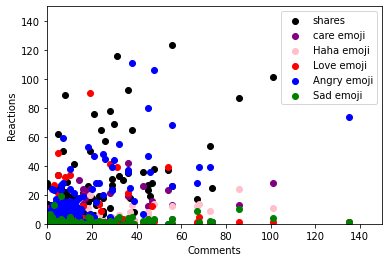

In [43]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [44]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1)]]


[[('alegremente', 1),
  ('animos', 1),
  ('burlar', 1),
  ('campana', 1),
  ('carta', 1),
  ('completo', 1),
  ('desgraciar', 1),
  ('difamar', 1),
  ('discursar', 1),
  ('divisivo', 1),
  ('enfocar', 1),
  ('exacerbar', 1),
  ('fan', 1),
  ('futuro', 1),
  ('gran', 1),
  ('harris', 1),
  ('indecencia', 1),
  ('medicos', 1),
  ('nombrar', 2),
  ('parar', 1),
  ('racismo', 1),
  ('racista', 1),
  ('seguir', 1),
  ('triunfar', 1),
  ('trump', 2),
  ('ultimar', 1),
  ('vicepresidente', 1),
  ('vida', 1)]]

## Buiding the Topic Model

In [45]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [46]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.058*"personal" + 0.057*"people" + 0.042*"governor" + 0.039*"everyone" + '
  '0.037*"derecho" + 0.036*"patriots" + 0.033*"terrorista" + 0.030*"clear" + '
  '0.029*"order" + 0.025*"amenazar"'),
 (1,
  '0.489*"trump" + 0.136*"america" + 0.044*"decir" + 0.027*"usar" + '
  '0.017*"violencia" + 0.014*"disturbio" + 0.014*"ideo" + 0.012*"agree" + '
  '0.011*"protestar" + 0.009*"bueno"'),
 (2,
  '0.305*"democrats" + 0.082*"radical" + 0.014*"pacific" + 0.011*"islander" + '
  '0.010*"essential" + 0.006*"join" + 0.000*"virus" + 0.000*"past" + '
  '0.000*"refuse" + 0.000*"permits"'),
 (3,
  '0.170*"political" + 0.066*"justice" + 0.000*"eyes" + 0.000*"partner" + '
  '0.000*"expressed" + 0.000*"commentator" + 0.000*"discussed" + '
  '0.000*"climate" + 0.000*"issues" + 0.000*"district"'),
 (4,
  '0.000*"habran" + 0.000*"gringo" + 0.000*"latinar" + 0.000*"jovencito" + '
  '0.000*"joven" + 0.000*"izquierdosos" + 0.000*"ismo" + 0.000*"inocular" + '
  '0.000*"lindo" + 0.000*"fundación"'),
 (5,
 

## Compute Model Perplexity and Coherence Score

In [47]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.175431925586455

Coherence Score:  0.44811073560452064


## Visualize the topics-keywords

In [48]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.397456 -0.132295       1        1  19.398672
12    -0.120636  0.335899       2        1  16.920639
14    -0.024700  0.117542       3        1  11.711308
6      0.012156 -0.022650       4        1   7.652842
9     -0.036384 -0.053232       5        1   7.166372
19     0.014397  0.048113       6        1   5.101149
0      0.028104 -0.032883       7        1   5.010480
5      0.017064 -0.015893       8        1   4.526261
11     0.040111 -0.026085       9        1   4.236660
7      0.036901 -0.018214      10        1   3.214818
17     0.040401 -0.025012      11        1   2.727812
18     0.042101 -0.025598      12        1   2.634090
16     0.040163 -0.025995      13        1   2.544162
15     0.043133 -0.005584      14        1   1.863541
2      0.042990 -0.024346      15        1   1.758588
13     0.045939 -0.021135      16        1   1.123232
8      0.045900 -0.020436      17        1   1.027252
3      0.044239 -0.022335      18        1   0.825574
10     0.043883 -0.016246      19        1   0.422986
4      0.041693 -0.013615      20        1   0.133565, topic_info=                      Term         Freq        Total Category  logprob  \
24                   trump  1703.000000  1703.000000  Default  30.0000   
166                america   482.000000   482.000000  Default  29.0000   
163              democrats    97.000000    97.000000  Default  28.0000   
152                  medio   128.000000   128.000000  Default  27.0000   
224                  votar   126.000000   126.000000  Default  26.0000   
167                country   137.000000   137.000000  Default  25.0000   
263                   race   137.000000   137.000000  Default  24.0000   
256                 really    81.000000    81.000000  Default  23.0000   
61              presidente   209.000000   209.000000  Default  22.0000   
165                   also   112.000000   112.000000  Default  21.0000   
339                  donar    77.000000    77.000000  Default  20.0000   
99                  racial    74.000000    74.000000  Default  19.0000   
499                    ano   169.000000   169.000000  Default  18.0000   
20                 racismo   168.000000   168.000000  Default  17.0000   
79                   negro    70.000000    70.000000  Default  16.0000   
450                debatir    93.000000    93.000000  Default  15.0000   
346                  decir   153.000000   153.000000  Default  14.0000   
569               personar   139.000000   139.000000  Default  13.0000   
205                  color    87.000000    87.000000  Default  12.0000   
38                   hacer   173.000000   173.000000  Default  11.0000   
377                liberal    66.000000    66.000000  Default  10.0000   
147             democratas    65.000000    65.000000  Default   9.0000   
397                 hablar   100.000000   100.000000  Default   8.0000   
270                   post   100.000000   100.000000  Default   7.0000   
492                 acusar   104.000000   104.000000  Default   6.0000   
128                federal    46.000000    46.000000  Default   5.0000   
70                     ver   101.000000   101.000000  Default   4.0000   
182               personal    53.000000    53.000000  Default   3.0000   
429                 people    52.000000    52.000000  Default   2.0000   
164                  mayor    59.000000    59.000000  Default   1.0000   
24                   trump  1702.479370  1703.678955   Topic1  -0.7160   
346                  decir   152.518936   153.718536   Topic1  -3.1285   
368                   usar    93.260765    94.460373   Topic1  -3.6204   
369              violencia    60.099876    61.299461   Topic1  -4.0598   
166                america   472.065430   482.301483   Topic1  -1.9987   
349              disturbio    47.911449    49.111034   Topic1  -4.2865   
354                   ideo    4

## Building LDA Mallet Model

In [49]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [50]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [51]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [52]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [53]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(18,
  [('millón', 0.029835390946502057),
   ('negro', 0.02880658436213992),
   ('estadounidense', 0.0257201646090535),
   ('cubano', 0.023662551440329218),
   ('terrorista', 0.02263374485596708),
   ('amenazar', 0.01440329218106996),
   ('objetivar', 0.01440329218106996),
   ('hispano', 0.013374485596707819),
   ('coronavirus', 0.013374485596707819),
   ('hombre', 0.013374485596707819)]),
 (10,
  [('presidente', 0.07761194029850746),
   ('ver', 0.046766169154228855),
   ('decir', 0.046766169154228855),
   ('hablar', 0.026865671641791045),
   ('pasar', 0.025870646766169153),
   ('preguntar', 0.022885572139303482),
   ('personar', 0.021890547263681594),
   ('violencia', 0.020895522388059702),
   ('ir', 0.01990049751243781),
   ('votar', 0.01990049751243781)]),
 (19,
  [('gente', 0.033480176211453744),
   ('querer', 0.02290748898678414),
   ('partir', 0.019383259911894272),
   ('vivir', 0.019383259911894272),
   ('hacer', 0.014977973568281937),
   ('poblar', 0.014096916299559472),
   ('

## Finding the optimal number of topics for LDA

In [54]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [55]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

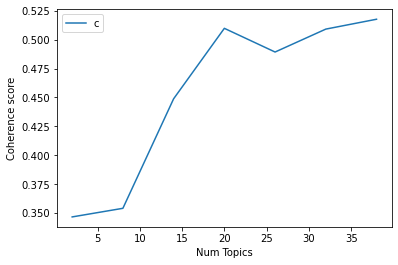

In [56]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3466
Num Topics = 8  has Coherence Value of 0.3541
Num Topics = 14  has Coherence Value of 0.4488
Num Topics = 20  has Coherence Value of 0.5098
Num Topics = 26  has Coherence Value of 0.4893
Num Topics = 32  has Coherence Value of 0.5091
Num Topics = 38  has Coherence Value of 0.5177


In [63]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.144*"democrats" + 0.070*"debatir" + 0.052*"trump" + 0.038*"medio" + '
  '0.026*"issue" + 0.024*"patriots" + 0.018*"legal" + 0.018*"radical" + '
  '0.018*"defense" + 0.017*"presidential"'),
 (1,
  '0.149*"america" + 0.100*"donar" + 0.085*"country" + 0.029*"radical" + '
  '0.028*"reform" + 0.027*"signed" + 0.025*"dislike" + 0.025*"agree" + '
  '0.022*"hatred" + 0.022*"control"'),
 (2,
  '0.032*"comunista" + 0.028*"izquierdo" + 0.022*"partir" + 0.021*"luchar" + '
  '0.020*"libertar" + 0.018*"hoy" + 0.018*"mundo" + 0.016*"socialista" + '
  '0.015*"controlar" + 0.014*"lograr"'),
 (3,
  '0.173*"trump" + 0.154*"america" + 0.061*"president" + 0.026*"decades" + '
  '0.023*"didnt" + 0.023*"control" + 0.020*"divided_america" + 0.019*"create" '
  '+ 0.018*"simple" + 0.016*"minutar"'),
 (4,
  '0.073*"post" + 0.057*"federal" + 0.049*"photos" + 0.042*"mexico" + '
  '0.031*"campaign" + 0.028*"country" + 0.026*"losar" + 0.025*"equal" + '
  '0.022*"lives" + 0.020*"americas"'),
 (5,
  '0.034*"g

## Finding the dominant topic in each sentence

In [64]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,13.0,0.0868,"racismo, odiar, social, mujer, blanco, pedir, hombre, gobernador, juez, poner","Racismo, enfoque divisivo e indecencia siguen siendo las ""cartas de triunfo"" del gran Donald... Desde difamar a los médicos que salvan vidas hasta el nombre de la futura vicepresidente Harris, la última parada de la campaña de Trump fue una completa desgracia. Trump se Burla Alegremente del Nombre de Kamala en un Discurso Racista y Exacerba los Ánimos de Sus Fans"
1,1,9.0,0.0962,"solo, marxista, tambien, protestar, policia, republicano, electoral, llegar, esperar, atacar","De aprobarse, los supremacistas podrían lanzarte su carro encima y alegar que lo hicieron por ""seguridad""... El compinche floridano de Trump lanza un ataque aterrador contra la Primera Enmienda. Gobernador Rep Propone Ley Que Criminaliza las Protestas de BLM y Legaliza Lanzar el Carro a los Manifestantes"
2,2,11.0,0.1172,"ver, hacer, democratas, hablar, apoyar, usar, presidente, pasar, prensar, querer","Este va directo para el que todavía tenga dudas de lo GRANDE que tú has hecho este país... El concepto de Trump de hacer a “América Grande de Nuevo” se traduce para muchos en un crecimiento desmesurado del racismo, el fanatismo, la supremacía y la ignorancia de tipos que se están saliendo con la suya sin rendir cuentas ante la ley. Quizás sea por eso que es refrescante ver a un fa... Gracias Querido Presidente Trump: Este es el Tipo de Honorable Actitud Que Tú Has Logrado en Este País"
3,3,14.0,0.0643,"color, male, states, people, crowd, businesses, degree, special, red, peacefully","Doral, home of Venezuelans in Florida, went crazy when Harris showed up!"
4,4,8.0,0.0717,"decir, personar, vida, creer, ir, preguntar, racista, racismo, ley, hacer","A eso es lo que realmente quieren llegar: a volver a separarnos a los negros y latinos de los blancos. No lo vamos a permitir... Los espectadores no podían creer lo que oían ante los últimos comentarios del senador que apoyaba a Trump. Para Este Senador Cuando el Racismo Era Ley, Eran los ""Buenos Tiempos de la Segregación"""
5,5,5.0,0.0956,"gente, dar, querer, vivir, socialista, hacer, poblar, llamar, verdad, historia",Nominada de Trump al Supremo Bajo Fuego por Defender Insultos Raciales en el Lugar de Trabajo... Su terrible decisión sobre la palabra n se sumó a la montaña de pruebas que demuestran que no es apta para la Corte Suprema. Ya no Basta Con Estar Institucionalizando el Racismo. Ahora Queremos Llevarlo a la Corte Suprema
6,6,18.0,0.1103,"presidente, grupo, estadounidense, unir, gran, familia, llevar, ganar, chino, saber","Fíjate bien. No es por siglos de EXPLOTACIÓN y EXCLUSIÓN, es porque ellos no quieren. ¿Será marrano el yerno presidencial?... El yerno del presidente sacó a relucir algo de su racismo asombroso durante un fallido intento de cortejar a los votantes. ¿Sabes Cuál es el Problema de los Afroamericanos? Pues Que No ""Quieren Tener Éxito"", Según Kushner"
7,7,15.0,0.0923,"tiempo, trabajar, poder, promover, generar, sociedad, tomar, crear, impulsar, objetivar","El Maestro de la Distracción intenta otra de las suyas, pero ya le conocemos bien... El presidente está tratando de cambiar la conversación de su vergonzosa falta de patriotismo para revertir el racismo poniendo fin a la capacitación en sensibilidad en las agencias federales. Trump Intenta Distraernos de sus Comentarios Antimilitares con una Nueva Batalla de Guerra Cultural"
8,8,10.0,0.0770,"negro, cubano, terrorista, millón, ciudad, negocio, publicar, amenazar, volver, hijo","Our right to vote has been oppressed since it was granted!😡 As Willie Velasquez taught: Latinos must quickly become sophisticated enough to realize that the historical reason republican controlled states, like Texas and South Carolina, have the highest incarceration rates and lowest educational achievement is not, as Trump and his cronies insist, because we are a bunch of dumb rapists and murderers but rath

## Find the most representative document for each topic

In [65]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.3251,"democrats, debatir, trump, medio, issue, patriots, legal, radical, defense, presidential","OPINION BASED ON TRUTH: Did the Corrupt Debate Commission Changes Topics for Debate because of Hunter, and Bidens Weak Foreign Policy? --------- The last debate was suppose to be about Foreign Policy before the revelation of Hunter Bidens emails, and add this to Joe Bidens dismal foreign policy and the the topics have suddenly changed. In fact, Obamas own Secretary of Defense, Robert Gates bla..."
1,1.0,0.3896,"america, donar, country, radical, reform, signed, dislike, agree, hatred, control",I will make it easier for folks who are too full of hatred to do any research. President Trump has done more in the past 4 years than Biden in his lifetime. Still waiting to see 1 good thing Biden had has done for America: Do you dislike that Trump made cruelty to animals a FELONY? Do you dislike that he signed a law ending the gag-order on pharmacists that prevented them from sharing money-sa...
2,2.0,0.7654,"comunista, izquierdo, partir, luchar, libertar, hoy, mundo, socialista, controlar, lograr","*USA🇺🇸está en Peligro!* *Sabía que estamos en Guerra*? Hoy toda la izquierda internacional intenta evitar que se concreten dos hechos fundamentales en esta parte del mundo. *Primero* y muy importante, que el Presidente sea reelecto... quieren evitar a toda costa que el presidente Norteamericano permanezca en la Casa Blanca y logre desbaratar el complot global que izquierdas y grandes capitale..."
3,3.0,0.4133,"trump, america, president, decades, didnt, control, divided_america, create, simple, minutar","ASK YOURSELF I am not a Democrat and my family is not, but I found this interesting from a Democrat.. OPEN LETTER TO DEMOCRATS I just have a few questions for you…. Let me start with, I already know you dont like President Trump...thats a given, SO lets move on from that... About the division of America.. Do you really blame Trump for that? How about when 67 of the DEMOCRATS didnt show up for ..."
4,4.0,0.3824,"post, federal, photos, mexico, campaign, country, losar, equal, lives, americas","Dont get it twisted. We were fired up for Bernie. Now were fired up to Vote Trump out. We dont support Biden smelling children. That needs to be addressed & that behavior needs to stop immediately especially if in fact he wins the 2020 election. It all comes down to choosing a lesser evil and its unfortunate the focus has moved to Biden smelling children. Im sorry, some are talking about peopl..."
5,5.0,0.7544,"gente, dar, querer, vivir, socialista, hacer, poblar, llamar, verdad, historia","Soy ciudadana americana de origen nicaragüense, por la Gracia De Dios, vivo en la ciudad de Miami, Florida hoy quiero compartir con ustedes un tema muy allegado a mi corazón que sangra día a día por lo que está viviendo mi país natal NICARAGUA y que yo no quiero se llegue a vivir en este hermoso país, que me acogió y al que agradezco, amo y respeto... los nicaragüenses celebramos en septiembr..."
6,6.0,0.3063,"political, liberal, justice, criminal, officer, governor, order, cultural, candidates, clear",🚨STRONG TRAFFIC CONTINUES🚨 1000+ VIEWS AND COUNTING! ➡️PLEASE SHARE!⬅️ Your FAVORITE PROFESSOR continues to call out #Liberals on their consistent nonsense!😎 Check out the LATEST EDITION of Real Talk With Fernando Uribe. The feedback has been AMAZING! I am PROUD to partner with Eyes On NJ News to bring you this weekly online show! The lineup and discussion included: ☑️ Protestors are a NUISANC...
7,7.0,0.2980,"trump, talk, dictator, daily, cages, gilroyfortrump_mariposa, paypal, pastar, politico, patriota","The difference between me and a lot of my Democratic friends.....You see Trump’s arrogance, I see Trump’s confidence. You see Trump’s nationalism, I see Trump’s patriotism. You hear Trump’s unsophisticated words, I hear Trump’s honesty. You see Trump’s racism, I see Trump’s words being misconstrued and twisted by the media

In [66]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [67]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,13.0,"racismo, odiar, social, mujer, blanco, pedir, hombre, gobernador, juez, poner",342.0,0.2498
1.0,9.0,"solo, marxista, tambien, protestar, policia, republicano, electoral, llegar, esperar, atacar",64.0,0.0467
2.0,11.0,"ver, hacer, democratas, hablar, apoyar, usar, presidente, pasar, prensar, querer",13.0,0.0095
3.0,14.0,"color, male, states, people, crowd, businesses, degree, special, red, peacefully",69.0,0.0504
4.0,8.0,"decir, personar, vida, creer, ir, preguntar, racista, racismo, ley, hacer",91.0,0.0665
5.0,5.0,"gente, dar, querer, vivir, socialista, hacer, poblar, llamar, verdad, historia",16.0,0.0117
6.0,18.0,"presidente, grupo, estadounidense, unir, gran, familia, llevar, ganar, chino, saber",101.0,0.0738
7.0,15.0,"tiempo, trabajar, poder, promover, generar, sociedad, tomar, crear, impulsar, objetivar",117.0,0.0855
8.0,10.0,"negro, cubano, terrorista, millón, ciudad, negocio, publicar, amenazar, volver, hijo",29.0,0.0212
9.0,9.0,"solo, marxista, tambien, protestar, policia, republicano, electoral, llegar, esperar, atacar",31.0,0.0226
